### **Ivan Murabito-s263138**
# Homework 2 DeepLearning and experiments on AlexNet




# Training from scratch


**Install requirements**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install --upgrade 'pillow'

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (6.2.1)


**Import libraries**

In this section i've installed and imported all stuffs needed for this homework (numpy,matplot,pil,torchvision etc etc)

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import pandas as pd 
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from copy import deepcopy


**Set Arguments**

Block of given arguments (LR,STEP_SIZE,EPOCHS etc)

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR_TEST = 0.05
LR_TEST_2=0.001
LR = 0.001           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS_TEST = 70
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE_TEST = 35  # How many epochs before decreasing learning rate (if using a step-down policy)
STEP_SIZE = 20
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 1

**Define Data Preprocessing**


I defined the transformations to apply to images in the dataset (both training and evaluation),
at first:


*   resize (256)
*   center-crop (224)
*   to Tensor
*   normalize (mean=.5 .5 .5 ) (std=.5 .5 .5)




In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])


**My custom dataset (Caltech) class** 


I created my custom dataset class, starting from the one released.
that load the images respectively from given train.txt and test.txt files.
I created two new functions that help the creation of dataset
- load_images(..)
- find_classes(..)

(easy to imagine their purpose :))

the dataset class are:
- init(..) : initial processes, when data are loaded (from txt in this case)
- len(..) : return the size of data
- getitem(..) : return data and label at orbitary index


In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys

TRAIN_PATH ='Homework2-Caltech101/train.txt'
TEST_PATH ='Homework2-Caltech101/test.txt'


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
def find_classes(txt_path):
    classes=[]
    f = open(txt_path)
    for l in f.readlines():
      x=l.split('/')
      if(not x[0] in classes): 
        classes.append(x[0])
    classes.remove('BACKGROUND_Google')
    #classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    print('FOUND {} CLASSES [{},{}..]'.format(len(classes),classes[0],classes[1]))
    return classes, class_to_idx

def load_images(root,txt_path,class_to_idx):
    images=[]
    f = open(txt_path)
    for path in f.readlines():
      label=path.split('/')[0]
      if(label in class_to_idx):
        image=(pil_loader(root+'/'+path.split('\n')[0]),class_to_idx[label])
        images.append(image)
    print('Loaded {} Images and label'.format(len(images)))
    return images
      


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        if(split == 'train'):
          self.txt_path=TRAIN_PATH
        if(split == 'test'):
          self.txt_path=TEST_PATH

        self.classes,self.class_to_idx=find_classes(self.txt_path) 

        self.samples=load_images(root,self.txt_path,self.class_to_idx) 
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

         # Provide a way to access image and label via index
         # Image should be a PIL Image
         # label can be int

        image,label =self.samples[index]
        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples)
        return length

**Useful function**

I wrote several usefull functions that I will use throughout the homework

in particular
- evaluate(..): test a model on given dataset
- plot_graph(..)
- train_and_validate(..): very useful function; given a model, optimizer, n_epoch and datasets and dataloaders
 train the model and evaluate it on each epoch on validation set.
at the end (after last epoch) plot two graphs : loss / epochs accuracy / epochs
and returns the best model found

In [0]:
def evaluate(model,test_dataset,test_dataloder,type_='Validation'):
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  cudnn.benchmark # Calling this optimizes runtime
  model.train(False) # Set Network to evaluation mode
  accuracy=0
  running_corrects = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    # Forward Pass
    outputs = model(images)
    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))
  print(' {} score: {} '.format(type_,accuracy),end = '')
  return accuracy
  
def plot_graph(x,y,x_label,y_label):
  plt.figure(figsize=((10,8)))
  plt.plot(x,y, color='blue')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show() 

def train_and_validate(n_epoch,model,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler):
  '''
  train the model and validate it on each epoch, 
  return the model with best score on validation set
  '''
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  current_step = 0
  best_model={'accuracy':0}
  accuracies=[] # accuracy for epoch
  loss_=[]
  # Start iterating over the epochs
  
  for epoch in range(n_epoch):
    medium_loss=0
    count_step=0
    print('\nepoch {}/{}, LR = {} '.format(epoch+1, n_epoch, scheduler.get_lr()),end = '')
    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      model.train() # Sets module in training mode
      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients
      # Forward pass to the network
      outputs = model(images)
      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      # Log loss
      #if current_step % LOG_FREQUENCY == 0:
        #print('Step {}, Loss {}'.format(current_step, loss.item()))
      medium_loss+=loss.item()
      count_step+=1
      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      current_step += 1
    medium_loss=medium_loss/count_step
    loss_.append(medium_loss)
    print(' loss : {}'.format(medium_loss),end = '')
    accuracy=evaluate(model,val_dataset,val_dataloader,type_='validation')
    accuracies.append(accuracy)
    if(accuracy > best_model['accuracy']):
      print(' BEST MODEL found!',end='')
      best_model['accuracy']=accuracy
      best_model['model']=deepcopy(model)
    scheduler.step()
  best_model['accuracies']=accuracies
  #ACCURACY/EPOCH GRAPH
  plot_graph(range(n_epoch),accuracies,'Epoch','Accuracy') 
  #loss/epoch graph
  plot_graph(range(n_epoch),loss_,'Epoch','medium loss')

  return best_model

**Prepare Dataset**

in this section i loaded two dataset from .txts; train and test (5784 images for train and 2893 for test)
nb: 
obviously the images are balanced for each class.

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset= Caltech(DATA_DIR,'train',transform=train_transform)
test_dataset= Caltech(DATA_DIR,'test',transform=eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893


**Split train into train and validation**




I've splitted train in train and validation (each 2892 images),

to maintain the balance I used odd indexes for validation and even for training.
(nb: this trick work only because the images are ordered)
for all the homework these datasets will be used.


In [0]:
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]

train_dataset=Subset(train_dataset,val_indexes)
val_dataset=Subset(train_dataset,train_indexes)
print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))



Training split: 2892
Validation split: 2892


**Prepare Dataloaders**

from pytorch docs:

`Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.`

Dataloaders help to put in ram a batch of data from dataset, help with parallelization and provide some usefull tools like shuffling and more.
there is a dataloader for each split (train,test,val)


In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

- Load the Alexnet (pytorch implementation) 
- change fc layer from 1000 output to 101 output (caltech classes)

In [0]:
net = alexnet() # Loading AlexNet model
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

Define:


*   criterion: cross entropy
*   param to oprimize: at firsts step of homework i will optimize all params of network (net.parameters())
*   optimizer: the optimizer update the weights based on the loss,in this case is used SGD with momentum
*   scheduler : dynamically change the LR 



In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR_TEST, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE_TEST, gamma=GAMMA)

##**Train**


To find a good model I didn't put all the parameters to optimize in a double/triple for (like a gridSearch)
but I did several experiments analyzing the progress of each model, first modifying the learning rate (the one given to me was too small, especially after splitting the train in train + validation)
and then the step size and the number of epochs.

for each epoch the model is evaluated on validation set.

the printed output below show the epoch,loss,val_score
at the end two graphs showing the trend of these variables over the epochs.

the printed output below show (..one of) the best model that i found over experiments:
- **LR:0.05**
- **50 epochs**
- **step size:35** 




epoch 1/50, LR = [0.05]  loss : 4.593657623637807 validation score: 0.09197786998616875  BEST MODEL found!
epoch 2/50, LR = [0.05]  loss : 4.4370271075855605 validation score: 0.09197786998616875 
epoch 3/50, LR = [0.05]  loss : 4.2419892224398525 validation score: 0.09197786998616875 
epoch 4/50, LR = [0.05]  loss : 4.2301602797074755 validation score: 0.09197786998616875 
epoch 5/50, LR = [0.05]  loss : 4.147969852794301 validation score: 0.09197786998616875 
epoch 6/50, LR = [0.05]  loss : 4.057804692875255 validation score: 0.15525587828492393  BEST MODEL found!
epoch 7/50, LR = [0.05]  loss : 3.869585644115101 validation score: 0.21542185338865838  BEST MODEL found!
epoch 8/50, LR = [0.05]  loss : 3.662203983827071 validation score: 0.2143845089903181 
epoch 9/50, LR = [0.05]  loss : 3.5391142151572486 validation score: 0.258298755186722  BEST MODEL found!
epoch 10/50, LR = [0.05]  loss : 3.505119735544378 validation score: 0.25622406639004147 
epoch 11/50, LR = [0.05]  loss : 3.

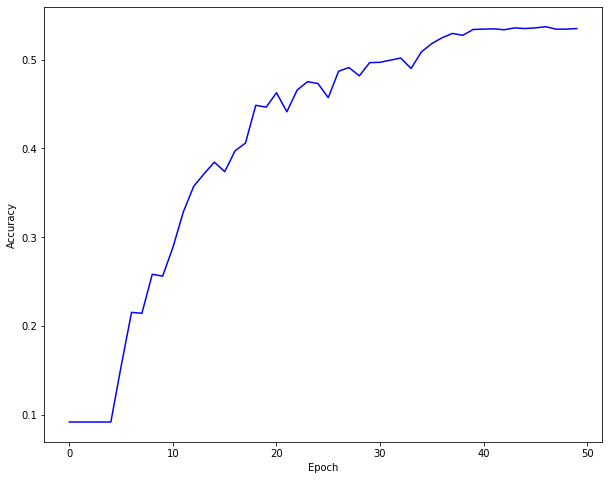

<Figure size 432x288 with 0 Axes>

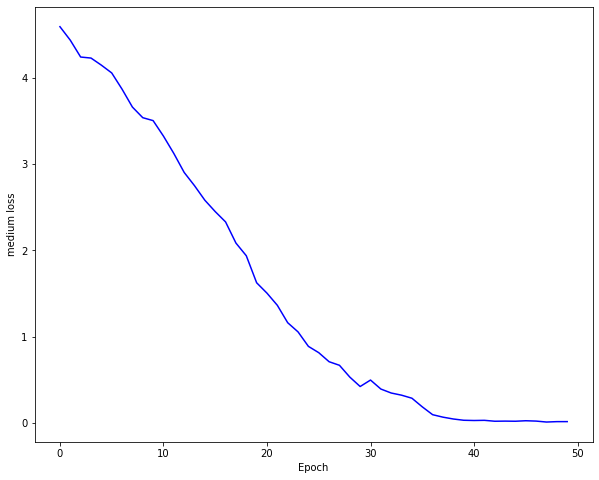

<Figure size 432x288 with 0 Axes>

In [0]:
# Train and evaluate with my custom function, return the best model found on all epochsa
# print 2 graphs showing ho varies the accuracy and the loss trough the epochs
best_model=train_and_validate(50,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)

##**Test**
evaluate the best model on test set

In [0]:
net = best_model['model']
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
accuracy=evaluate(net,test_dataset,test_dataloader,type_='test set ')


 test set  score: 0.5368129968890425 

| LR   | EPOCH | STEP | LOSS    | MAX SCORE ON VALIDATION SET |  SCORE ON TEST |
|------|-------|------|---------|-----------------------------|----------------|
| 0.1  | 30    | 20   | diverge |                             |                |
| 0.05 | 60    | 20   | 0.34    | 0.47                        |                |
| 0.05 | 40    | 10   | 3.9     | 0.12                        |                |
| 0.05 | 50    | 35   | 0.016   | 0.54                         | 0.54           |
| 0.01 | 40    | 25   | 0.37    | 0.34  
                      |                
|0.001 (stock) | 30 (stock)| 20 (stock)| 2.5 | 0.16


as you can see from the table there is a lot of difference in the results of the various tests with different hyperparameters.

it can be noted, however, that the starting learning rate 0.001 is too small to converge in acceptable times/epochs.

nb: i evaluated on test set only the best model that i found, all others models are evaluated (for each epochs) only on validation set, and the validation score refers only the best model in all iterations.
instead the loss is the loss at the last epochs.


# Transfer Learning

in this section I do the same experiments as before but this time on the pretrained net. 

for 'pretrained' i mean:
```
Use the weights learned by training on a large related dataset as a starting point for
training on the small dataset 
```

it can be seen that the pretrained network converges much much faster, so I preferred to use fewer epochs also to reduce the execution time!

**Prepare dataset with new transform (mean and std of imageNet)**

the procedure is the same as before but this time in the normalize function (into transforms) i use mean and std of imagenet:


*   mean: (0.485, 0.456, 0.406),
*   std:   (0.229, 0.224, 0.225)





In [0]:
# params
LR = 0.01           # The initial Learning Rate
NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15

# normalize function with mean and standard deviation of imagenet
alex_pretrained_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset= Caltech(DATA_DIR,'train',transform=alex_pretrained_transform)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=alex_pretrained_transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
train_dataset=Subset(train_dataset,val_indexes)
val_dataset=Subset(train_dataset,train_indexes)
print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893
Training split: 2892
Validation split: 2892


**load alexnet pretrained**


the procedure is the same as before ,except for:


```
net = alexnet(pretrained=True)
```



In [0]:
net = alexnet(pretrained=True) # Loading AlexNet model pretrained
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Alexnet structure:**

In [0]:
print(net)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Train the model pretrained** and found best hyper-params


epoch 1/20, LR = [0.01]  loss : 2.9351478815078735 validation score: 0.6524896265560166  BEST MODEL found!
epoch 2/20, LR = [0.01]  loss : 0.8723358620296825 validation score: 0.7538035961272476  BEST MODEL found!
epoch 3/20, LR = [0.01]  loss : 0.38032312420281494 validation score: 0.8132780082987552  BEST MODEL found!
epoch 4/20, LR = [0.01]  loss : 0.14736244624311273 validation score: 0.8215767634854771  BEST MODEL found!
epoch 5/20, LR = [0.01]  loss : 0.0816753598099405 validation score: 0.8226141078838174  BEST MODEL found!
epoch 6/20, LR = [0.01]  loss : 0.0730857253074646 validation score: 0.8246887966804979  BEST MODEL found!
epoch 7/20, LR = [0.01]  loss : 0.07041364942084659 validation score: 0.8257261410788381  BEST MODEL found!
epoch 8/20, LR = [0.01]  loss : 0.04311365938999436 validation score: 0.8333333333333334  BEST MODEL found!
epoch 9/20, LR = [0.01]  loss : 0.029842208393595436 validation score: 0.834716459197787  BEST MODEL found!
epoch 10/20, LR = [0.01]  loss 

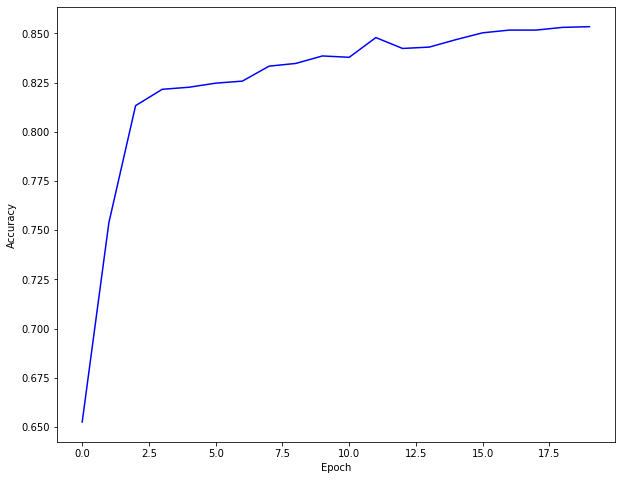

<Figure size 432x288 with 0 Axes>

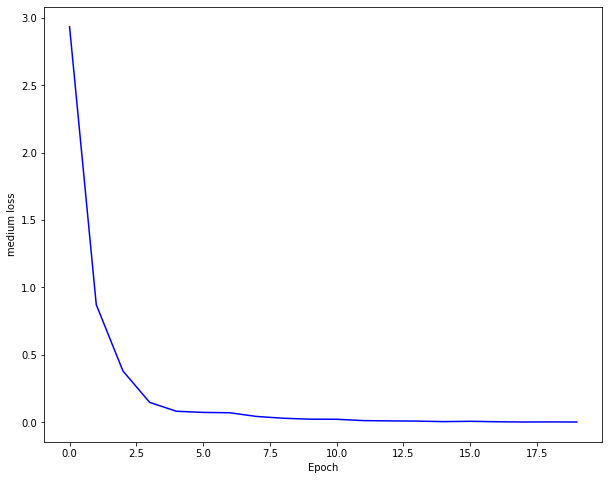

<Figure size 432x288 with 0 Axes>

In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
best_model_pretrained=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)



|lr    |epochs    |step    |loss   |score (validation)  |
----------|--------|--------|-------|---------|
|0.05   |20 |15 | div!  | div!|
|0.01 | 20 |15 | 0.001 | 0.853 |
|0.01   |30 | 15| 0.0012 | 0.852|
|0.008   |20 |15 | 0.0024 | 0.85 |
|0.005   |15 | 10| 0.007  | 0.84 |
|0.005   |30 |25 | 0.002  | 0.853|
|0.001  |30 | 25| 0.0015 | 0.83|

as you can see the results are much better than the previous model.
even at the second epoch we reach a 75% accuracy on the validation set, which for me is a very good result;
until the accuracy reach, after 20 epoch, just over 85%, impressive!

but i tuned again different hyperparameters because the best ones in the "not pretrained" model didn't perform very well.


*i could even continue to decrease the number of epochs and by making a more precise tuning, obtain even better results*



In [0]:
net = best_model_pretrained['model']
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

accuracy=evaluate(net,test_dataset,test_dataloader,'test')


 test score: 0.85309367438645 

## **Freezing layer**
- LR= 0.01
- 20 epochs
- step size = 15

in this section I try the hyper-parameters found previously:
- training only the fully connected layers
- training only the convolutional layers

In [0]:
LR = 0.01           # best params
NUM_EPOCHS = 20     
STEP_SIZE = 15

**training and test only the fully connected layers**


epoch 1/20, LR = [0.01]  loss : 2.9304029074582187 validation score: 0.6825726141078838  BEST MODEL found!
epoch 2/20, LR = [0.01]  loss : 0.7810212861407887 validation score: 0.8146611341632088  BEST MODEL found!
epoch 3/20, LR = [0.01]  loss : 0.3022911792451685 validation score: 0.8274550484094052  BEST MODEL found!
epoch 4/20, LR = [0.01]  loss : 0.14918840337883343 validation score: 0.8520055325034578  BEST MODEL found!
epoch 5/20, LR = [0.01]  loss : 0.0780270675366575 validation score: 0.8516597510373444 
epoch 6/20, LR = [0.01]  loss : 0.05839121781966903 validation score: 0.8520055325034578 
epoch 7/20, LR = [0.01]  loss : 0.045082019472664055 validation score: 0.8509681881051175 
epoch 8/20, LR = [0.01]  loss : 0.03657011366025968 validation score: 0.8516597510373444 
epoch 9/20, LR = [0.01]  loss : 0.028887460177594967 validation score: 0.8540802213001383  BEST MODEL found!
epoch 10/20, LR = [0.01]  loss : 0.029052125120704823 validation score: 0.8537344398340249 
epoch 11/

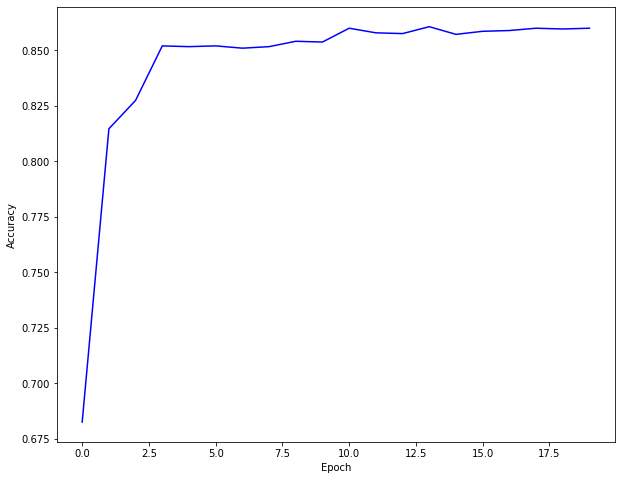

<Figure size 432x288 with 0 Axes>

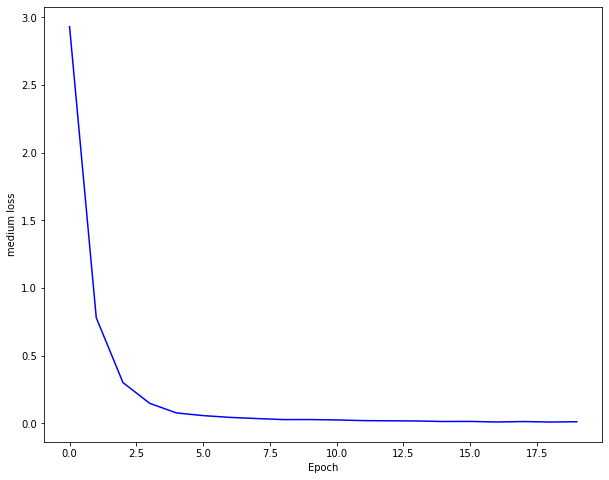

<Figure size 432x288 with 0 Axes>

 (full conn layers) test score: 0.8603525751814726 

In [0]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.classifier.parameters() # only full connected layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_full_connected=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_full_connected['model'],test_dataset,test_dataloader,'(full conn layers) test')

**training and test only the conv layers**


epoch 1/20, LR = [0.01]  loss : 4.68530425158414 validation score: 0.09820193637621023  BEST MODEL found!
epoch 2/20, LR = [0.01]  loss : 4.289907932281494 validation score: 0.20262793914246197  BEST MODEL found!
epoch 3/20, LR = [0.01]  loss : 3.773331642150879 validation score: 0.25345781466113415  BEST MODEL found!
epoch 4/20, LR = [0.01]  loss : 3.46509296243841 validation score: 0.29356846473029047  BEST MODEL found!
epoch 5/20, LR = [0.01]  loss : 3.2764456272125244 validation score: 0.3184647302904564  BEST MODEL found!
epoch 6/20, LR = [0.01]  loss : 3.1582499850880015 validation score: 0.34923928077455046  BEST MODEL found!
epoch 7/20, LR = [0.01]  loss : 3.062823317267678 validation score: 0.36894882434301524  BEST MODEL found!
epoch 8/20, LR = [0.01]  loss : 2.922023144635287 validation score: 0.40076071922544954  BEST MODEL found!
epoch 9/20, LR = [0.01]  loss : 2.8436369462446733 validation score: 0.3900414937759336 
epoch 10/20, LR = [0.01]  loss : 2.7632934830405493 val

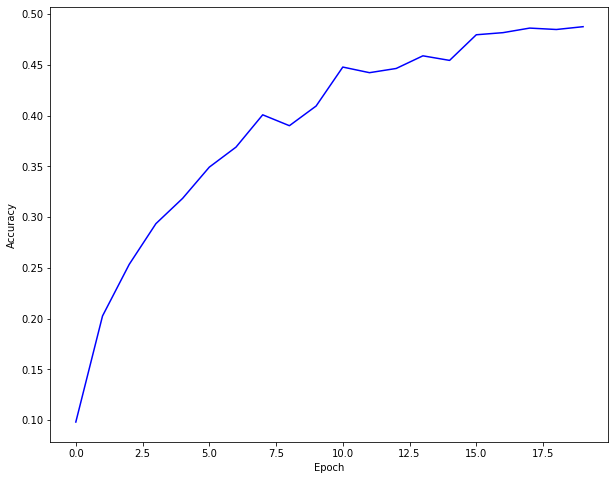

<Figure size 432x288 with 0 Axes>

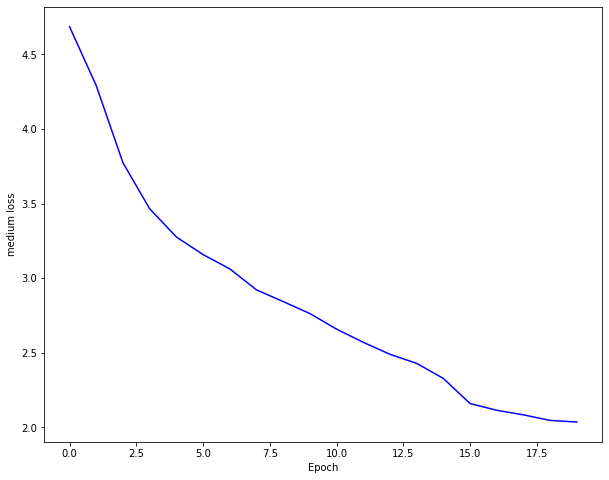

<Figure size 432x288 with 0 Axes>

 (conv layers) test score: 0.4873833390943657 

In [0]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.features.parameters() # only fully connected layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_conv=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_conv['model'],test_dataset,test_dataloader,'(conv layers) test')

**Compare results**


as it was easy to imagine,training only the FC, the model converge much much faster then training only the CONV,

in this case even the results (training only FC) are a little bit better than training the entire network,
I didn't expect this behavior, probably because it manages to converge earlier than train the entire network.

ACCURACY OBTAINED WHEN TRAINING FULLY CONNECTED LAYER


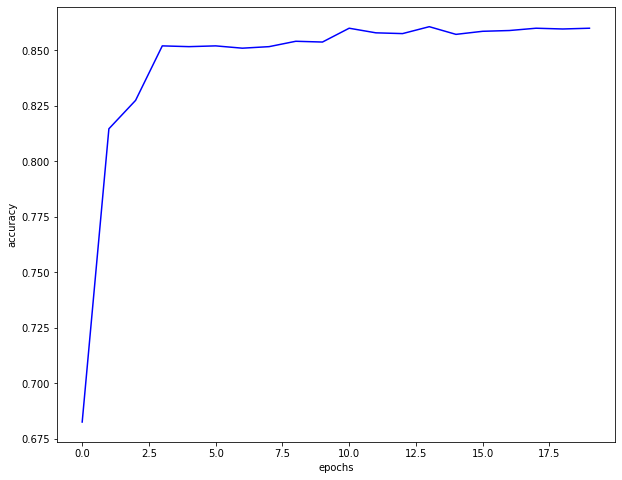

<Figure size 432x288 with 0 Axes>

ACCURACY OBTAINED WHEN TRAINING CONVOLUTIONAL LAYER


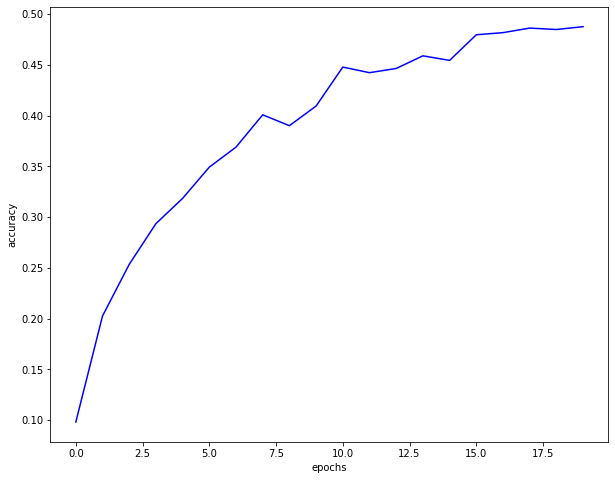

<Figure size 432x288 with 0 Axes>

In [0]:
print('ACCURACY OBTAINED WHEN TRAINING FULLY CONNECTED LAYER')
plot_graph(range(NUM_EPOCHS),best_model_full_connected['accuracies'],'epochs','accuracy')
print('ACCURACY OBTAINED WHEN TRAINING CONVOLUTIONAL LAYER')
plot_graph(range(NUM_EPOCHS),best_model_conv['accuracies'],'epochs','accuracy')

compare three different type of training:

| type of training (layers) | loss  | score(val) | score(test) |
|---------------------------|-------|------------|-------------|
| all                       | 0.001 | 0.85       | 0.85        |
| only Fully connected      | 0.01  | 0.86       | 0.86        |
| only convolutional        | 2  | 0.48       | 0.48        |

# Data augmentation

in this section I experiment with different types of image transformations:
- (stock) centerCrop
- randomCrop
- centerCrop + randomHorizontalFlip
- centerCrop + randomRotation(180°)

## Prepare datasets with new transforms

In [0]:
LR = 0.01           # best params
NUM_EPOCHS = 20     
STEP_SIZE = 15

# normalize function with mean and standard deviation
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_1 = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_2 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
transform_3 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(180),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
print('[stock transforms]\n',transform)
print('[transforms #1]\n',transform_1)
print('[transform #2]\n',transform_2)
print('[transform #3]\n',transform_3)


train_dataset= Caltech(DATA_DIR,'train',transform=transform_3)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=transform_3)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
train_dataset=Subset(train_dataset,val_indexes)
val_dataset=Subset(train_dataset,train_indexes)
print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



[stock transforms]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transforms #1]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transform #2]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
[transform #3]
 Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    RandomRotation(degrees=(-180, 180), resample=False, expand=False)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSE


epoch 1/20, LR = [0.01]  loss : 3.51328706741333 validation score: 0.4664591977869986  BEST MODEL found!
epoch 2/20, LR = [0.01]  loss : 1.9228394681757146 validation score: 0.6099585062240664  BEST MODEL found!
epoch 3/20, LR = [0.01]  loss : 1.2947211265563965 validation score: 0.6355463347164592  BEST MODEL found!
epoch 4/20, LR = [0.01]  loss : 1.029720203443007 validation score: 0.6255186721991701 
epoch 5/20, LR = [0.01]  loss : 0.8175604180856184 validation score: 0.6493775933609959  BEST MODEL found!
epoch 6/20, LR = [0.01]  loss : 0.6362503062595021 validation score: 0.648686030428769 
epoch 7/20, LR = [0.01]  loss : 0.5876784324645996 validation score: 0.6666666666666666  BEST MODEL found!
epoch 8/20, LR = [0.01]  loss : 0.519824204119769 validation score: 0.6628630705394191 
epoch 9/20, LR = [0.01]  loss : 0.4559565945105119 validation score: 0.6424619640387276 
epoch 10/20, LR = [0.01]  loss : 0.4546502015807412 validation score: 0.6573305670816044 
epoch 11/20, LR = [0.01

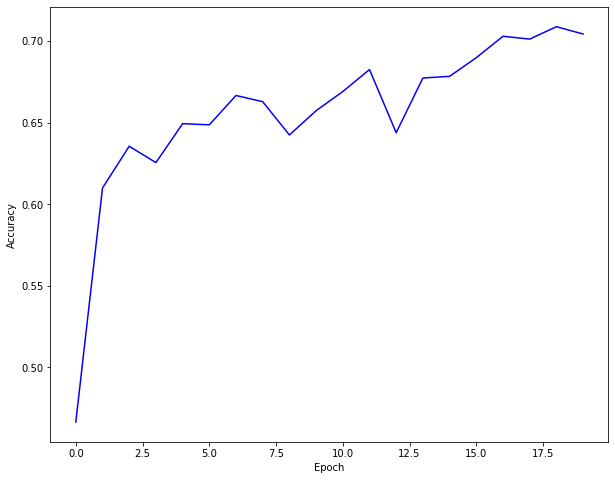

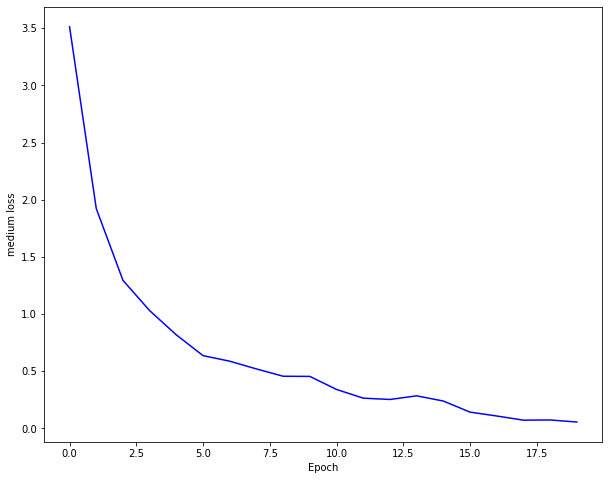

 test score: 0.7034220532319392 

In [0]:
net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() # all params
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) 
cudnn.benchmark
best_model_augmentation=train_and_validate(NUM_EPOCHS,net,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_augmentation['model'],test_dataset,test_dataloader,'test')

|       | transforms                            | loss  | score (test) |
|-------|--------------------------------------|-------|--------------|
| stock | center-crop                          | 0.001 | 0.85         |
| 1     | random crop                          | 0.018 | 0.833        |
| 2     | center-crop + random horizontal flip | 0.008  | 0.84        |
| 3     | center-crop + random rotation (180°) | 0.05  | 0.7          |


this time I couldn't get better results than the previous ones (but quite similar).
however I think that using different types of transformations greatly helps to reduce overfitting (wee can see this on the loss wich is medium higher than the previous)

*Another way can be increase the cardinality of data by concatenate different sets with different transformations*

# **Beyond AlexNet**

## **Resnet**
*Very deep network using residual connection.*

Resnet is very different model and much deeper than alexnet;

it starts from the hypothesis that deep models are more difficult to optimize;

solution: use layers to fit residual F(x) = H(x) + x instead of H(x) directly

resnet is composed by "residual blocks", every block has two 3x3 conv layers

since the network is much deeper, it is necessary to lower (even a lot!) the batch size to avoid saturating the gpu ram.

*I've also tried the **vgg16** but i couldn't get it to work at its best, and the training was really really slow. and sometimes (even with a very lower batch size) bring Colab to crash for too much Vram request*


**resnet vs alexnet vs vgg16**

we can see the huge structural differences between these models.

In [0]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True) 
vgg=models.vgg16(pretrained=True)
print('-------ALEXNET-----')
print(alexnet)
print('-------RESNET-----')
print(resnet)
print('-------VGG16-----')
print(vgg)


-------ALEXNET-----
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

**Test with resnet**

In [0]:
LR = 0.02         
NUM_EPOCHS = 30     
STEP_SIZE = 20
NUM_CLASSES = 101
BATCH_SIZE = 126
# normalize function with mean and standard deviation
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])
train_dataset= Caltech(DATA_DIR,'train',transform=transform)  # make dataset with custom transform (mean and std of imagenet)
test_dataset= Caltech(DATA_DIR,'test',transform=transform)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]
val_indexes=[i+1 for i in train_indexes]
#train and val
train_dataset=Subset(train_dataset,val_indexes)
val_dataset=Subset(train_dataset,train_indexes)
print('Training split: {}'.format(len(train_dataset)))
print('Validation split: {}'.format(len(val_dataset)))
#dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

resnet.fc=nn.Linear(512, NUM_CLASSES)
vgg.classifier[-1]=nn.Linear(4096, NUM_CLASSES)

FOUND 101 CLASSES [accordion,airplanes..]
Loaded 5784 Images and label
FOUND 101 CLASSES [accordion,airplanes..]
Loaded 2893 Images and label
Train Dataset: 5784
Test Dataset: 2893
Training split: 2892
Validation split: 2892



epoch 1/30, LR = [0.02]  loss : 2.8487802147865295 validation score: 0.7078146611341632  BEST MODEL found!
epoch 2/30, LR = [0.02]  loss : 0.6694851856340062 validation score: 0.8734439834024896  BEST MODEL found!
epoch 3/30, LR = [0.02]  loss : 0.17020560157569972 validation score: 0.9121715076071922  BEST MODEL found!
epoch 4/30, LR = [0.02]  loss : 0.05504009423946792 validation score: 0.9177040110650069  BEST MODEL found!
epoch 5/30, LR = [0.02]  loss : 0.025027294177562 validation score: 0.9256569847856155  BEST MODEL found!
epoch 6/30, LR = [0.02]  loss : 0.014805962289260193 validation score: 0.9270401106500692  BEST MODEL found!
epoch 7/30, LR = [0.02]  loss : 0.011133433192629705 validation score: 0.9242738589211619 
epoch 8/30, LR = [0.02]  loss : 0.00903661233711649 validation score: 0.9298063623789765  BEST MODEL found!
epoch 9/30, LR = [0.02]  loss : 0.0077403674579479475 validation score: 0.9291147994467497 
epoch 10/30, LR = [0.02]  loss : 0.006755170052532445 validatio

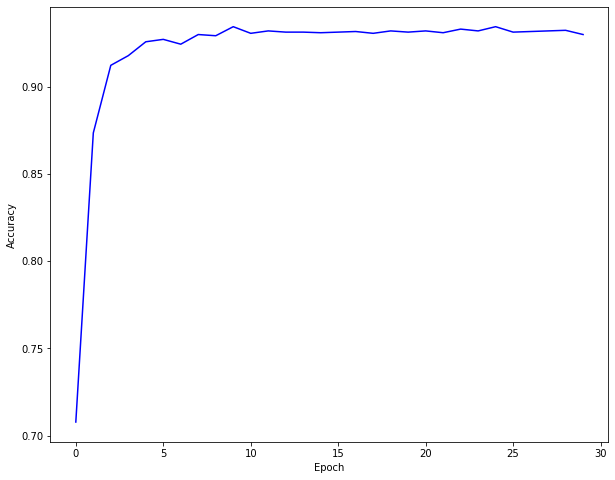

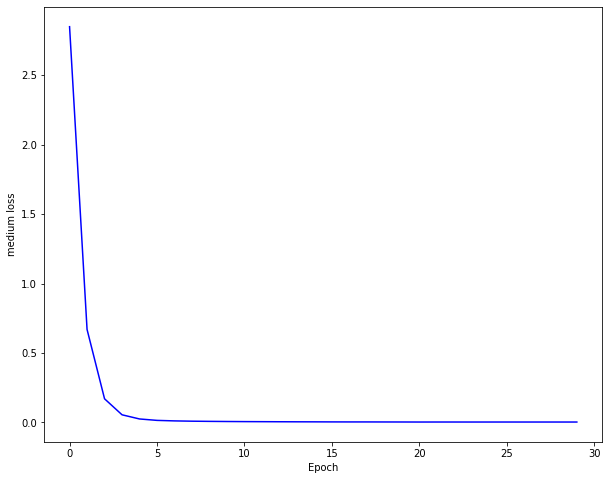

 test score: 0.9339785689595576 

In [0]:
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = resnet.parameters() # all params
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
resnet = resnet.to(DEVICE) 
cudnn.benchmark
best_model_resnet=train_and_validate(NUM_EPOCHS,resnet,train_dataloader,val_dataset,val_dataloader,optimizer,criterion,scheduler)
accuracy=evaluate(best_model_resnet['model'],test_dataset,test_dataloader,'test')

this 